In [1]:
import numpy as np
from scipy.linalg import svd, hankel, eig
from matplotlib import pyplot as plt
import scipy
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(999)

In [3]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(DenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, latent_size).double()
        )

    
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size).double(),
            nn.Tanh(),
            nn.Linear(hidden_size, input_size).double()
        )


    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [4]:
noise = 1.0
overlap = 0.2# 0: HF
Tmax = 750
dt = 1

In [5]:
device = 'cuda'
input_size = Tmax 
hidden_size = 1024
output_size = Tmax
latent_size = Tmax // 2
num_epochs = 5000
learning_rate = 0.01

In [6]:
def generate_samples(E, psi0, dt=1, nb=100):
    S = np.zeros(nb, dtype=np.complex128)
    
    for j in trange(nb):
        S[j] = np.sum(np.abs(psi0)**2 * np.exp(-1j * E * j * dt))
    
    return S

In [7]:
def lam2lamt(lam, lammin, lammax):
    lamt = np.pi / 2 * (lam - (lammin + lammax) / 2) / (lammax - lammin)
    return lamt

In [8]:
def lamt2lam(lamt, lammin, lammax):
    lam = lamt * 2 / np.pi * (lammax - lammin) + (lammin + lammax) / 2
    return lam

In [9]:
def generate_phi(overlap, N):
    phi = np.zeros((N,1))
    phi[0] = np.sqrt(overlap)
    phi[1:] = np.sqrt((1 - phi[0]**2) / (N - 1))
    return phi

In [10]:
seed = 100
np.random.seed(seed)

In [12]:
data_cr2 = scipy.io.loadmat('../../data/Cr2_4000.mat')
psiHF = data_cr2['psiHF']
E = data_cr2['E']

In [13]:
Et = lam2lamt(E,E[0],E[-1])

In [14]:
if overlap == 0:
    dataS = generate_samples(Et,psiHF,dt,Tmax)
    phi = psiHF
else:
    phi = generate_phi(overlap,len(Et));
    print('generated phi')
    dataS = generate_samples(Et,phi,dt,Tmax);

generated phi


100%|██████████| 750/750 [00:00<00:00, 5042.83it/s]


Text(0.5, 1.0, 'True dynamics')

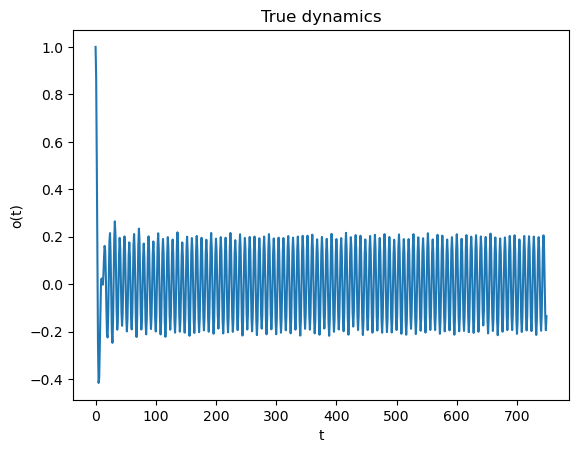

In [15]:
plt.plot(dataS.real)
plt.xlabel('t')
plt.ylabel('o(t)')
plt.title('True dynamics')

In [16]:
tdataS = []
num_trajs = 2000
for i in range(num_trajs):
    ndataS = (dataS + noise * np.random.randn(Tmax) + 1j * noise * np.random.randn(Tmax)).real
    tdataS.append(ndataS)

In [17]:
noisydataSt = torch.tensor(np.array(tdataS)).double()
noisydataSt.shape

torch.Size([2000, 750])

Text(0.5, 1.0, 'Noisy dynamics')

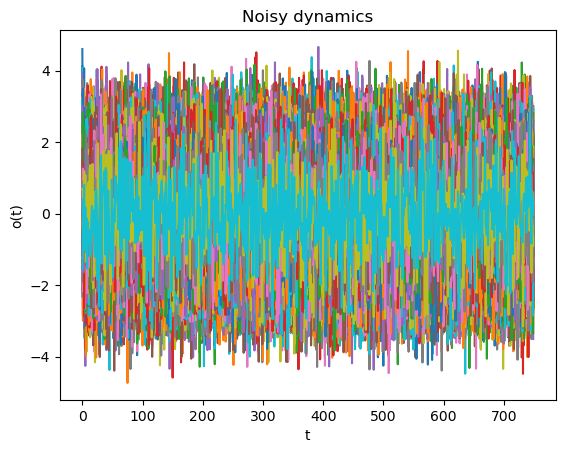

In [18]:
for i in range(noisydataSt.shape[0]):
    plt.plot(noisydataSt[i, :]);
plt.xlabel('t')
plt.ylabel('o(t)')
plt.title('Noisy dynamics')

In [18]:
class NoisyTimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx]

In [19]:
dataset = NoisyTimeSeriesDataset(noisydataSt.to(device))

In [20]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
model = DenoisingAutoencoder(input_size, hidden_size, latent_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

In [22]:
for epoch in trange(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        reconstruction = model(batch.double())
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 2/5000 [00:03<2:04:47,  1.50s/it]

Epoch [1/5000], Loss: 1.3178


  2%|▏         | 102/5000 [00:18<12:04,  6.76it/s]

Epoch [101/5000], Loss: 1.1161


  4%|▍         | 202/5000 [00:32<10:39,  7.50it/s]

Epoch [201/5000], Loss: 1.1761


  6%|▌         | 302/5000 [00:45<10:24,  7.53it/s]

Epoch [301/5000], Loss: 1.5301


  8%|▊         | 402/5000 [00:59<10:12,  7.50it/s]

Epoch [401/5000], Loss: 0.9800


 10%|█         | 502/5000 [01:12<10:04,  7.44it/s]

Epoch [501/5000], Loss: 1.2973


 12%|█▏        | 602/5000 [01:25<09:45,  7.51it/s]

Epoch [601/5000], Loss: 1.4898


 14%|█▍        | 702/5000 [01:40<10:23,  6.89it/s]

Epoch [701/5000], Loss: 1.0225


 16%|█▌        | 802/5000 [01:54<10:19,  6.77it/s]

Epoch [801/5000], Loss: 1.4064


 18%|█▊        | 902/5000 [02:09<10:04,  6.78it/s]

Epoch [901/5000], Loss: 1.1935


 20%|██        | 1002/5000 [02:24<09:27,  7.05it/s]

Epoch [1001/5000], Loss: 1.1136


 22%|██▏       | 1102/5000 [02:38<09:32,  6.81it/s]

Epoch [1101/5000], Loss: 1.4065


 24%|██▍       | 1202/5000 [02:53<09:19,  6.79it/s]

Epoch [1201/5000], Loss: 1.0166


 26%|██▌       | 1302/5000 [03:07<09:02,  6.81it/s]

Epoch [1301/5000], Loss: 1.2817


 28%|██▊       | 1402/5000 [03:22<08:38,  6.94it/s]

Epoch [1401/5000], Loss: 1.3603


 30%|███       | 1502/5000 [03:37<08:25,  6.92it/s]

Epoch [1501/5000], Loss: 0.9953


 32%|███▏      | 1602/5000 [03:51<08:24,  6.73it/s]

Epoch [1601/5000], Loss: 1.3424


 34%|███▍      | 1702/5000 [04:06<08:02,  6.83it/s]

Epoch [1701/5000], Loss: 1.2021


 36%|███▌      | 1802/5000 [04:20<07:07,  7.49it/s]

Epoch [1801/5000], Loss: 1.0960


 38%|███▊      | 1902/5000 [04:33<07:07,  7.25it/s]

Epoch [1901/5000], Loss: 1.4249


 40%|████      | 2002/5000 [04:47<06:41,  7.47it/s]

Epoch [2001/5000], Loss: 1.0908


 42%|████▏     | 2102/5000 [05:00<06:27,  7.48it/s]

Epoch [2101/5000], Loss: 1.1987


 44%|████▍     | 2202/5000 [05:14<06:16,  7.43it/s]

Epoch [2201/5000], Loss: 1.4076


 46%|████▌     | 2302/5000 [05:27<06:46,  6.63it/s]

Epoch [2301/5000], Loss: 0.9930


 48%|████▊     | 2402/5000 [05:43<06:52,  6.29it/s]

Epoch [2401/5000], Loss: 1.3294


 50%|█████     | 2502/5000 [05:59<06:31,  6.38it/s]

Epoch [2501/5000], Loss: 1.2028


 52%|█████▏    | 2602/5000 [06:15<06:19,  6.33it/s]

Epoch [2601/5000], Loss: 1.0353


 54%|█████▍    | 2702/5000 [06:30<06:02,  6.34it/s]

Epoch [2701/5000], Loss: 1.4230


 56%|█████▌    | 2802/5000 [06:46<05:40,  6.46it/s]

Epoch [2801/5000], Loss: 1.1174


 58%|█████▊    | 2902/5000 [07:01<05:12,  6.72it/s]

Epoch [2901/5000], Loss: 1.1482


 60%|██████    | 3002/5000 [07:15<04:34,  7.28it/s]

Epoch [3001/5000], Loss: 1.3015


 62%|██████▏   | 3102/5000 [07:28<04:23,  7.20it/s]

Epoch [3101/5000], Loss: 1.0228


 64%|██████▍   | 3202/5000 [07:43<04:19,  6.93it/s]

Epoch [3201/5000], Loss: 1.3077


 66%|██████▌   | 3302/5000 [07:57<04:04,  6.95it/s]

Epoch [3301/5000], Loss: 1.3657


 68%|██████▊   | 3402/5000 [08:12<03:52,  6.86it/s]

Epoch [3401/5000], Loss: 1.0448


 70%|███████   | 3502/5000 [08:26<03:38,  6.87it/s]

Epoch [3501/5000], Loss: 1.3799


 72%|███████▏  | 3602/5000 [08:41<03:19,  7.01it/s]

Epoch [3601/5000], Loss: 1.1820


 74%|███████▍  | 3702/5000 [08:55<03:08,  6.87it/s]

Epoch [3701/5000], Loss: 1.1252


 76%|███████▌  | 3802/5000 [09:09<02:41,  7.42it/s]

Epoch [3801/5000], Loss: 1.3979


 78%|███████▊  | 3902/5000 [09:23<02:26,  7.50it/s]

Epoch [3901/5000], Loss: 1.0241


 80%|████████  | 4002/5000 [09:37<02:19,  7.16it/s]

Epoch [4001/5000], Loss: 1.2449


 82%|████████▏ | 4102/5000 [09:52<02:18,  6.49it/s]

Epoch [4101/5000], Loss: 1.3698


 84%|████████▍ | 4202/5000 [10:07<02:02,  6.50it/s]

Epoch [4201/5000], Loss: 0.9788


 86%|████████▌ | 4302/5000 [10:23<01:50,  6.34it/s]

Epoch [4301/5000], Loss: 1.3459


 88%|████████▊ | 4402/5000 [10:39<01:31,  6.51it/s]

Epoch [4401/5000], Loss: 1.2473


 90%|█████████ | 4502/5000 [10:54<01:18,  6.32it/s]

Epoch [4501/5000], Loss: 1.0745


 92%|█████████▏| 4602/5000 [11:08<00:53,  7.51it/s]

Epoch [4601/5000], Loss: 1.4115


 94%|█████████▍| 4702/5000 [11:22<00:39,  7.50it/s]

Epoch [4701/5000], Loss: 1.0800


 96%|█████████▌| 4802/5000 [11:35<00:28,  6.90it/s]

Epoch [4801/5000], Loss: 1.1475


 98%|█████████▊| 4902/5000 [11:50<00:14,  6.85it/s]

Epoch [4901/5000], Loss: 1.3637


100%|██████████| 5000/5000 [12:04<00:00,  6.90it/s]


In [24]:
model.eval()
#evaluate model with one of the training trajectories
with torch.no_grad():
    prediction = model(noisydataSt[0, :].double().to(device))

/global/common/software/nersc/pm-2022q4/sw/pytorch/2.0.1/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


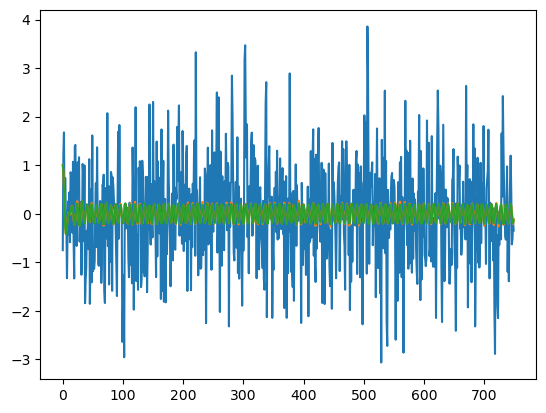

In [30]:
plt.plot(noisydataSt[0, :])
plt.plot(prediction.cpu())
plt.plot(dataS)

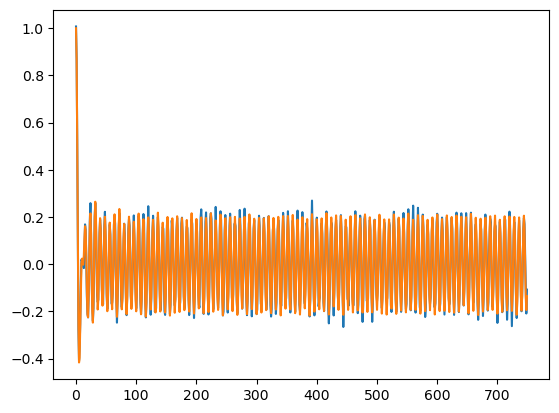

In [31]:
plt.plot(prediction.cpu())
plt.plot(dataS)

In [40]:
#sample new noisy trajectory
test_dataS = torch.tensor((dataS + 2.0 * noise * np.random.randn(Tmax) + 1j * noise * np.random.randn(Tmax)).real).double().to(device)

In [41]:
with torch.no_grad():
    prediction = model(test_dataS)

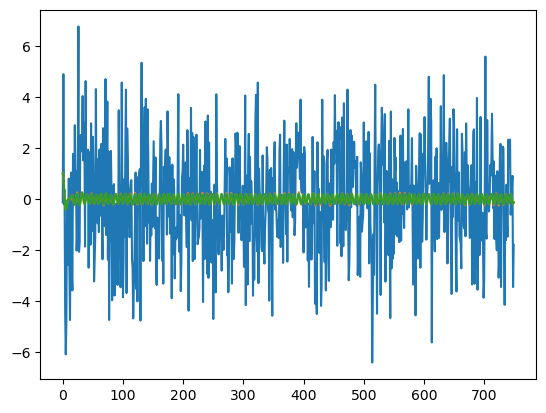

In [42]:
plt.plot(test_dataS.cpu())
plt.plot(prediction.cpu())
plt.plot(dataS)

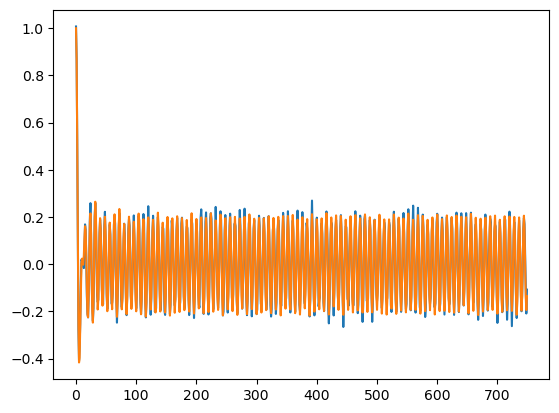

In [43]:
plt.plot(prediction.cpu())
plt.plot(dataS)

In [47]:
torch.save(model.state_dict(), 'denoiser_numtraj=2000_noise=1.0.pth')